In [ ]:
pip install mastml pymatgen scikit-lego linear-tree gplearn cbfv deepchem duecredit matplotlib pandas scikit-learn

Initial DataFrame:
   Chemical formula Band gap       Crystallinity Color
0  Bi$_{2}$Te$_{3}$    0.153  Single crystalline   NaN
1        Mg$_{2}$Ge    0.567  Single crystalline   NaN
2              CoSi    0.045  Single crystalline   NaN
3              NaBr    7.025  Single crystalline   NaN
4        Ca$_{2}$Sn      0.9     Polycrystalline   NaN

Filtered DataFrame (after dropping 'Color'):
   Chemical formula Band gap       Crystallinity
0  Bi$_{2}$Te$_{3}$    0.153  Single crystalline
1        Mg$_{2}$Ge    0.567  Single crystalline
2              CoSi    0.045  Single crystalline
3              NaBr    7.025  Single crystalline
4        Ca$_{2}$Sn      0.9     Polycrystalline

Cleaned DataFrame:
  Chemical formula  Band gap       Crystallinity
0           Bi2Te3     0.153  Single crystalline
1            Mg2Ge     0.567  Single crystalline
2             CoSi     0.045  Single crystalline
3             NaBr     7.025  Single crystalline
4            Ca2Sn     0.900     Polycrystalli

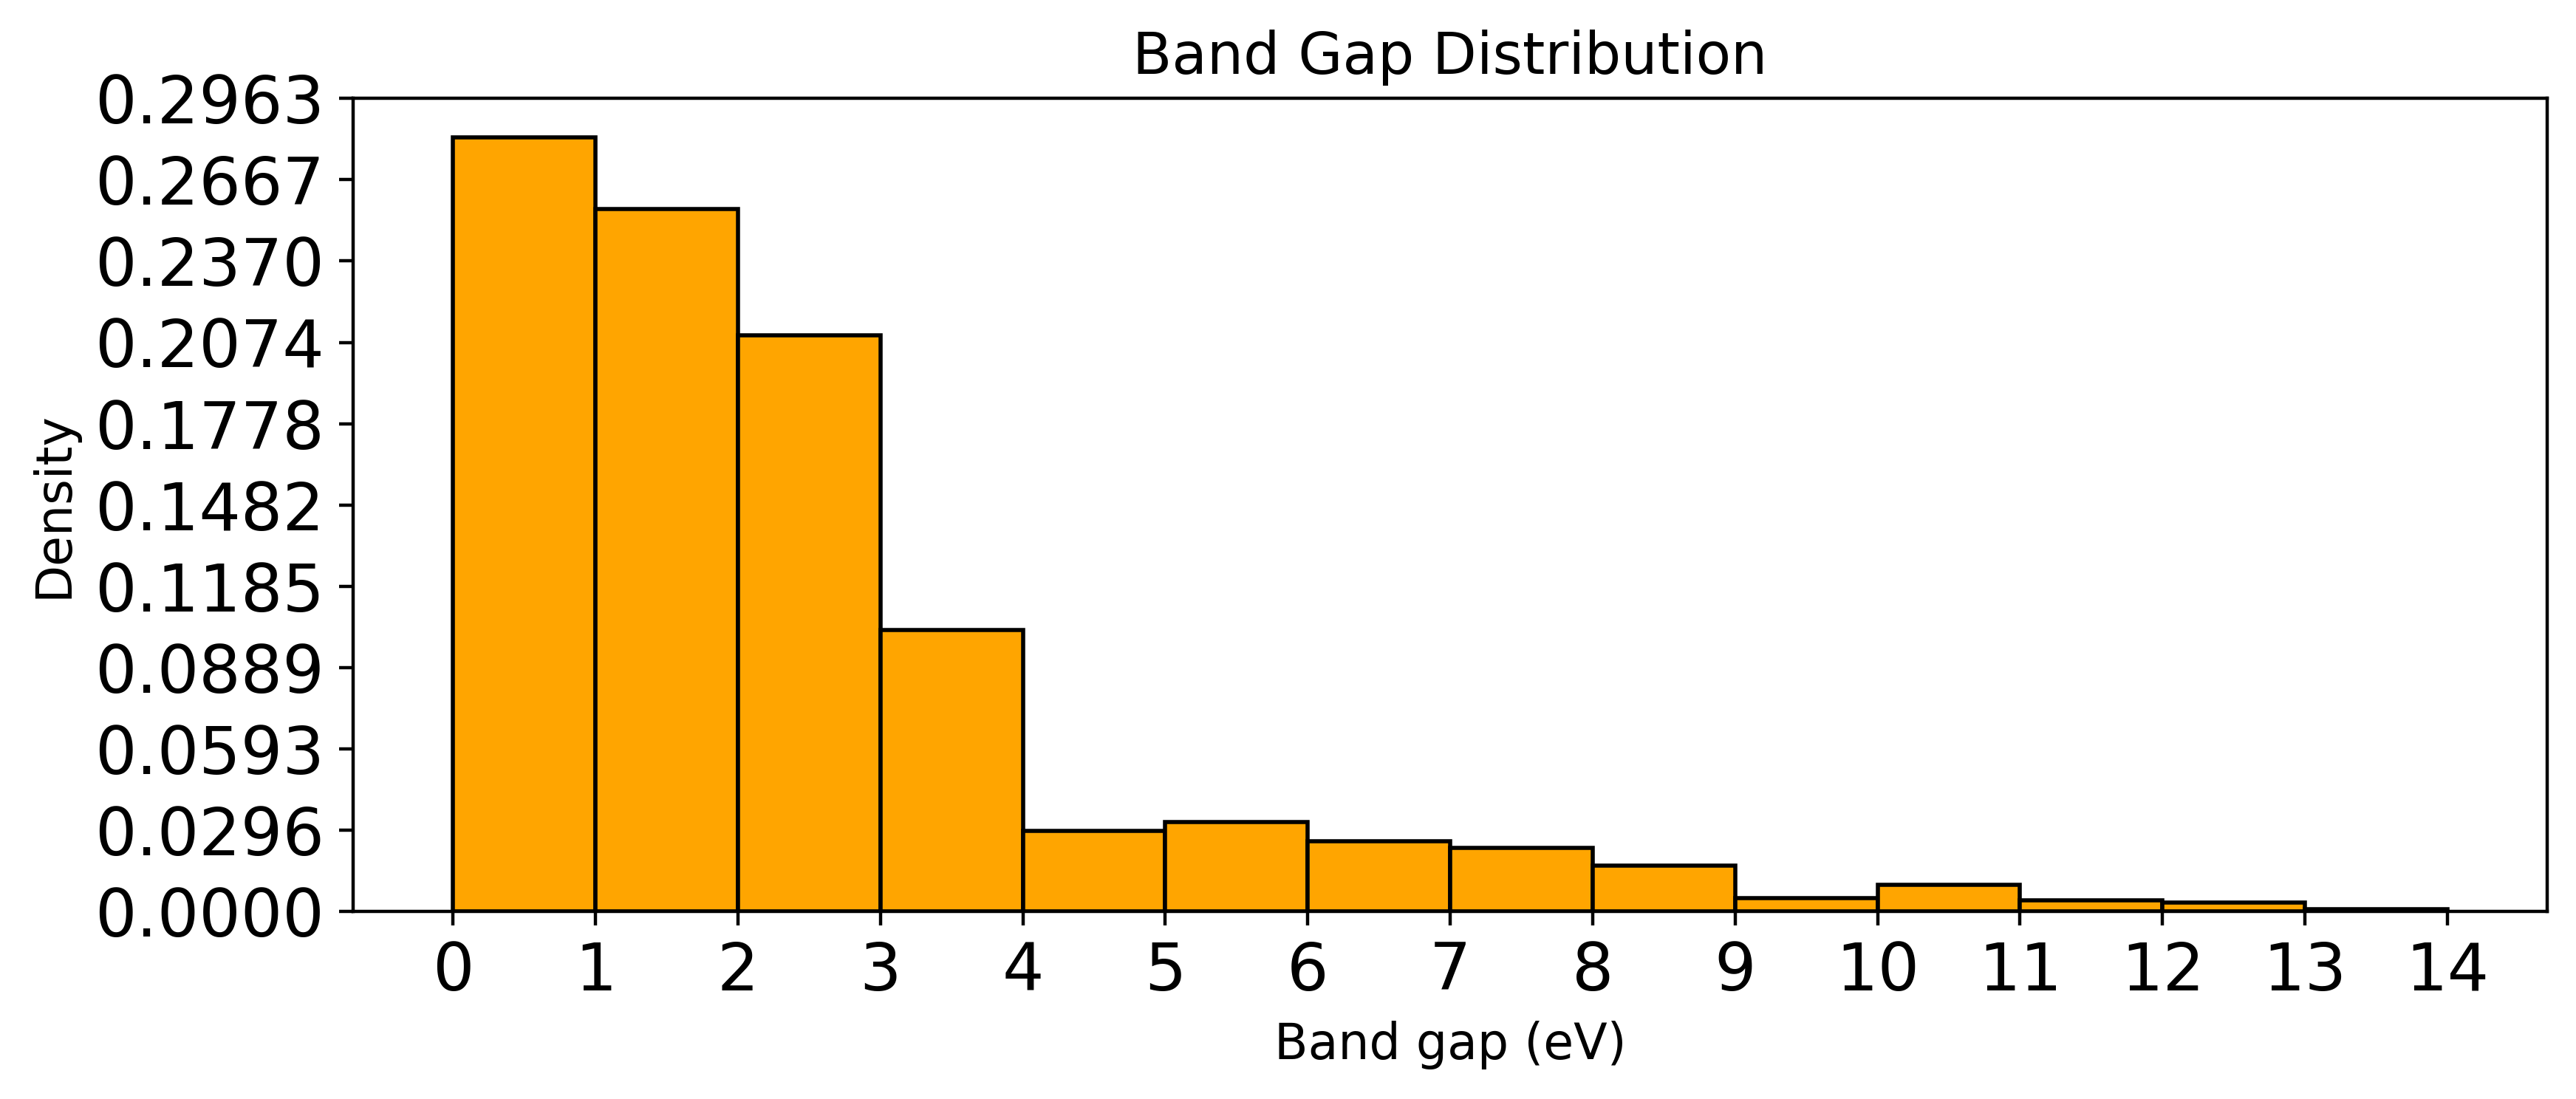


Unique Chemical Formulas:
['Bi2Te3' 'Mg2Ge' 'CoSi' 'NaBr' 'Ca2Sn' 'As2S3' 'ZnO' 'Cu2Se' 'GeTe'
 'CaF2' 'Sb2Se3' 'InAs' 'CdI2' 'La2S3' 'Mg3Sb2' 'Cu2Te' 'PbTe' 'CaO'
 'Eu3As2' 'AgBr' 'ZnTe' 'ZrSe3' 'HgS' 'Cr2O3' 'GeSe2' 'LaB6' 'MgO' 'CdSb'
 'As2Se3' 'NaI' 'CdAs2' 'InSb' 'AlAs' 'As4S4' 'SmSe' 'CdO' 'Cu2S' 'SnCl2'
 'RbI' 'FeI2' 'C' 'HgI2' 'Ce2Se3' 'Eu2O3' 'RbCl' 'PbBr2' 'As2O3' 'SnBr2'
 'KI' 'SnO2' 'Pr2Se3' 'Mg2Sn' 'MnS' 'SnSe' 'MoO3' 'Ag2Te' 'TlBr' 'EuS'
 'Dy2S3' 'BiI3' 'EuTe' 'MgTe' 'Si' 'As2S5' 'AgCl' 'Te' 'Bi0.85Sb0.15'
 'Bi0.97Sb0.03' 'AlB' 'PbSe' 'MnF2' 'Ag2Se' 'TiSe2' 'Bi0.91Sb0.09' 'GaSb'
 'LiF' 'Sb2S3' 'GeS' 'V4O7' 'GaSe' 'CdTe' 'HgTe' 'ZrS3' 'Se' 'UO2' 'KBr'
 'GaAs' 'Fe2Te3' 'K3Sb' 'Bi2O3' 'GaS' 'Zn4Sb3' 'PdO' 'HgBr2' 'PtSb2'
 'PtAs2' 'NiS' 'La2Se3' 'Cr2S3' 'ZnS' 'GeO2' 'Sb2O3' 'ThO2' 'In2Se' 'ZnSb'
 'HfS3' 'Lu2O3' 'Sb0.71As0.29' 'Na3Sb' 'V2O5' 'Bi0.9Sb0.1' 'CeO2' 'PbS'
 'TiTe2' 'MoTe2' 'CaSe' 'OsSb2' 'In2Te3' 'Mg2Si' 'MnO' 'ReO3' 'Ta2O5'
 'PbO' 'InSe' 'Nb2O5' 'PrO2' 'B' 'Ca2Si'

In [ ]:
# Import necessary libraries
# MAST-ML imports
from mastml.mastml import Mastml
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.data_splitters import SklearnDataSplitter  # Additional options: NoSplit, LeaveOutPercent
from mastml.feature_generators import ElementalFeatureGenerator  # Additional option: OneHotGroupGenerator
from mastml.hyper_opt import GridSearchCV  # Additional options: GridSearch, RandomizedSearch, BayesianSearch
# from mastml.learning_curve import LearningCurve  # Uncomment if needed
from mastml.metrics import Metrics

# Standard library imports
import os
import time
import random
from copy import copy
from collections import Counter

# Third-party library imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.utils
from sklearn import tree
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline

import pymatgen
import re
from pymatgen.core.composition import Composition

# Set random seed for reproducibility
seed = 12345123
np.random.seed(seed)
random.seed(seed)
sklearn.utils.check_random_state(seed)

# Step 1: Load the Dataset
# Raw URL of the dataset
data_url = 'https://raw.githubusercontent.com/Adrita-Khan/BandGapAlign/main/data/citrination-export.csv'
mastml_df = pd.read_csv(data_url)

# Display the first few rows
print("Initial DataFrame:")
print(mastml_df.head())

# Step 2: Data Cleaning and Preprocessing

# Drop the 'Color' column from the dataframe
mastml_df_filtered = mastml_df.drop(columns=['Color'])

# Uncomment one of the following lines to filter rows based on 'Crystallinity':
# Retain only rows where 'Crystallinity' is 'Single crystalline'
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"] == 'Single crystalline']

# Retain only rows where 'Crystallinity' is 'Polycrystalline'
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"] == 'Polycrystalline']

# Display the filtered dataframe
print("\nFiltered DataFrame (after dropping 'Color'):")
print(mastml_df_filtered.head())

# Convert 'Band gap' column to numeric, coercing errors to NaN to exclude rows with invalid values
mastml_df_filtered['Band gap'] = pd.to_numeric(mastml_df_filtered['Band gap'], errors='coerce')

# Clean 'Chemical formula' column by removing special characters (e.g., subscripts, superscripts, etc.)
mastml_df_filtered['Chemical formula'] = mastml_df_filtered['Chemical formula'].str.replace(r'[$_{}]', '', regex=True)

# Drop rows with missing (NaN) values across the dataframe
mastml_df_filtered = mastml_df_filtered.dropna()

# Display the cleaned dataframe
print("\nCleaned DataFrame:")
print(mastml_df_filtered.head())

# Further Filtering based on 'Band gap' if needed
# Uncomment the following lines to apply additional filtering:

# Remove rows where 'Band gap' is greater than 5.0
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered['Band gap'] <= 5.0]

# Remove rows where 'Band gap' is less than 0.2
# mastml_df_filtered = mastml_df_filtered[mastml_df_filtered['Band gap'] >= 0.2]

# Display the filtered dataframe
print("\nDataFrame after optional 'Band gap' filtering:")
print(mastml_df_filtered.head())

# Step 3: Exploratory Data Analysis

# Statistics for the band gap values in the data set
band_gap_stats = mastml_df_filtered["Band gap"].describe().round(3)
print("\nStatistics for 'Band gap':")
print(band_gap_stats)

# Function to plot histogram
def histogram_plot(data, bins_range=(0, 14), bin_width=1, color='orange', edge_color='black', title='Band Gap Distribution', xlabel='Band gap (eV)', ylabel='Density', figsize=(9, 4), dpi=400):
    """
    Plots a histogram for the provided data with customizable options.
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Plot the histogram
    ax.hist(data, bins=np.arange(bins_range[0], bins_range[1] + bin_width, bin_width), density=True, color=color, edgecolor=edge_color, lw=1)

    # Set axis labels and title
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set x and y ticks based on the data range
    ax.set_xticks(np.arange(bins_range[0], bins_range[1] + bin_width, bin_width))
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 11))  # 0 to max in 0.1 increments

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot histogram of 'Band gap' column
histogram_plot(mastml_df_filtered["Band gap"].astype("float"))

# Display unique 'Chemical formula' values in the cleaned DataFrame
unique_chemical_formulas = mastml_df_filtered["Chemical formula"].unique()
print("\nUnique Chemical Formulas:")
print(unique_chemical_formulas)
print(f"Total unique chemical formulas: {len(unique_chemical_formulas)}")

# Step 4: Chemical Formula Cleaning and Parsing

# Function to clean chemical formulas
def clean_chemical_formula(formula):
    """
    Cleans the chemical formula by:
    - Replacing LaTeX-like subscript formatting ($_{}) with numeric subscripts.
    - Converting fractional compositions into a format parsable by pymatgen.
    """
    # Replace LaTeX-like subscript formatting ($_{...}$) with numeric subscripts
    cleaned_formula = re.sub(r'\$_\{([0-9.]+)\}\$', r'\1', formula)

    # Replace fractional subscripts in specific cases (e.g., Bi$_{0.85}$Sb$_{0.15}$ -> Bi0.85Sb0.15)
    cleaned_formula = re.sub(r'([A-Za-z]+)\$_\{([0-9.]+)\}\$', r'\1\2', cleaned_formula)
    return cleaned_formula

# Clean the "Chemical formula" column
mastml_df_filtered["Chemical formula"] = mastml_df_filtered["Chemical formula"].apply(clean_chemical_formula)

# Verify the cleaned formulas
print("\nCleaned Chemical Formulas:")
print(mastml_df_filtered["Chemical formula"].unique())

# Parse out individual elements using pymatgen's Composition parser
element_list = []
failed_formulas = []

for idx in mastml_df_filtered.index:
    formula = mastml_df_filtered.loc[idx, "Chemical formula"]
    try:
        # Parse the formula with pymatgen's Composition
        composition = Composition(formula)
        element_list.extend([element.symbol for element in composition.elements])  # Add element symbols to the list
    except Exception as e:
        # Log failed formulas for further inspection
        print(f"Failed to parse formula: {formula}, Error: {e}")
        failed_formulas.append(formula)

# Display the parsed elements
print("\nParsed Elements:")
print(set(element_list))

# Display formulas that could not be parsed
if failed_formulas:
    print("\nFormulas that failed to parse:")
    print(failed_formulas)
else:
    print("\nAll formulas parsed successfully.")

# Step 5: Feature Analysis

# Setup a counter to count each element
temp_counter = Counter(element_list)
element_tuples = list(zip(list(temp_counter.keys()), list(temp_counter.values())))
element_df = pd.DataFrame(element_tuples, columns=["Element", "Count"])
element_df_sorted = element_df.sort_values(by=["Count"], ascending=False)

print("\nElement Counts:")
print(element_df_sorted)

# Step 6: Prepare Data for MAST-ML

# Define data and target
data = mastml_df_filtered['Chemical formula']
target = mastml_df_filtered['Band gap']

# Define feature types
feature_types = ['composition_avg', 'max', 'min', 'difference']



In [ ]:
# Step 7: Feature Generation using MAST-ML's ElementalFeatureGenerator

from mastml.feature_generators import ElementalFeatureGenerator

# Define feature types
feature_types = ['composition_avg', 'max', 'min', 'difference']

# Prepare the data for feature generation
# Select only the 'Chemical formula' column for featurization
featurize_df = mastml_df_filtered[['Chemical formula']].copy()

# Initialize the ElementalFeatureGenerator with 'featurize_df' and 'feature_types'
feature_generator = ElementalFeatureGenerator(featurize_df, feature_types=feature_types)

# Generate features by passing the DataFrame to fit_transform
X_features_tuple = feature_generator.fit_transform(featurize_df)

# Check if X_features_tuple is a tuple and unpack it
if isinstance(X_features_tuple, tuple):
    X_features, additional_info = X_features_tuple
    print("Successfully unpacked X_features and additional_info.")
else:
    X_features = X_features_tuple
    print("X_features is not a tuple. Proceeding accordingly.")

# Inspect the columns in X_features
print("Columns in X_features:", X_features.columns.tolist())

# Inspect additional_info if needed
print("\nAdditional Information from Feature Generation:")
print(additional_info)

# Combine the generated features with the target variable
X_features['target'] = mastml_df_filtered['Band gap'].values

# Verify columns after adding 'target'
print("\nColumns after adding 'target':", X_features.columns.tolist())

# Separate features and target
X = X_features.drop(columns=['target'])  # Only drop 'target'
y = X_features['target']

# Display the generated features
print("\nGenerated Features:")
print(X.head())


Featurizing compositions:: 1258it [00:00, 2278.88it/s]


Dropping 4/352 generated columns due to missing values
Successfully unpacked X_features and additional_info.
Columns in X_features: ['AtomicNumber_composition_average', 'AtomicNumber_difference', 'AtomicNumber_max_value', 'AtomicNumber_min_value', 'AtomicRadii_composition_average', 'AtomicRadii_difference', 'AtomicRadii_max_value', 'AtomicRadii_min_value', 'AtomicVolume_composition_average', 'AtomicVolume_difference', 'AtomicVolume_max_value', 'AtomicVolume_min_value', 'AtomicWeight_composition_average', 'AtomicWeight_difference', 'AtomicWeight_max_value', 'AtomicWeight_min_value', 'BCCefflatcnt_composition_average', 'BCCefflatcnt_difference', 'BCCefflatcnt_max_value', 'BCCefflatcnt_min_value', 'BCCenergy_pa_composition_average', 'BCCenergy_pa_difference', 'BCCenergy_pa_max_value', 'BCCenergy_pa_min_value', 'BCCfermi_composition_average', 'BCCfermi_difference', 'BCCfermi_max_value', 'BCCfermi_min_value', 'BCCmagmom_composition_average', 'BCCmagmom_difference', 'BCCmagmom_max_value', 'B

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the model
model = RandomForestRegressor(random_state=seed)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', model)
])


In [ ]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=12345123))])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Mean Squared Error: {mse:.3f}")
print(f"Test R^2 Score: {r2:.3f}")



Test Mean Squared Error: 0.537
Test R^2 Score: 0.901


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# Perform cross-validation
cv_scores = cross_val_score(
    pipeline, X, y, cv=cv, scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation of MSE
mean_mse = -cv_scores.mean()
std_mse = cv_scores.std()

print(f"\nCross-Validation Mean MSE: {mean_mse:.3f}")
print(f"Cross-Validation MSE Standard Deviation: {std_mse:.3f}")



Cross-Validation Mean MSE: 0.491
Cross-Validation MSE Standard Deviation: 0.094


In **band gap prediction**, the evaluation of whether a model is "good" or "bad" depends on:

### Context-Specific Factors
1. **Accuracy Needs in Band Gap Prediction**:
   - In materials science, accurately predicting the band gap is crucial for designing materials with specific electronic, optical, or thermal properties.
   - The acceptable **MSE** depends on the range of band gap values in the dataset:
     - If band gaps range between 0–5 eV, an **MSE of 0.491** corresponds to a root mean squared error (RMSE) of about 0.7 eV, which could be reasonable for some exploratory studies but may be insufficient for precise applications like photovoltaics or semiconductors.

2. **Benchmark Comparison**:
   - Compare the MSE with existing models in the field (e.g., Density Functional Theory (DFT)-based models or machine learning benchmarks).
   - If the model achieves similar or better performance at a fraction of the computational cost, it might be considered good.

3. **Model Consistency (Standard Deviation 0.094)**:
   - A small standard deviation across folds is a good sign, suggesting that the model generalizes well.

### Recommendations for Improvement
If the **MSE of 0.491** seems too high for the goals:
1. **Feature Engineering**:
   - Include physical or chemical descriptors (e.g., atomic radii, electronegativity).
   - Use domain-specific features, like crystal structure or density.

2. **Model Complexity**:
   - Experiment with more sophisticated models (e.g., deep learning, ensemble methods).
   - Use transfer learning if pre-trained models are available.

3. **Data Quality**:
   - Ensure high-quality, diverse, and balanced data for training.
   - Address any noise or inconsistencies in the data.

4. **Domain Knowledge**:
   - Incorporate theoretical insights to refine features or model assumptions.

For high-precision applications, aim for an **MSE significantly lower than 0.491**, ideally <0.1 (depending on dataset and objectives). If exploratory or qualitative insights are sufficient, this MSE might be acceptable.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)

# Best cross-validation score
best_cv_mse = -grid_search.best_score_
print(f"\nBest Cross-Validation MSE: {best_cv_mse:.3f}")



Best Parameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}

Best Cross-Validation MSE: 0.483


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Retrieve the best estimator
best_pipeline = grid_search.best_estimator_

# Make predictions on the test set
y_pred_optimized = best_pipeline.predict(X_test)

# Calculate evaluation metrics
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"\nOptimized Test Mean Squared Error: {mse_optimized:.3f}")
print(f"Optimized Test R^2 Score: {r2_optimized:.3f}")



Optimized Test Mean Squared Error: 0.155
Optimized Test R^2 Score: 0.971


In [ ]:
# Feature Importances
importances = best_pipeline.named_steps['regressor'].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)



Feature Importances:
                               Feature  Importance
60         Density_composition_average    0.320527
109                   Group_difference    0.097620
49                   Column_difference    0.094034
248  MiracleRadius_composition_average    0.065331
24        BCCfermi_composition_average    0.034970
..                                 ...         ...
205              IsNobleGas_difference    0.000000
204     IsNobleGas_composition_average    0.000000
185               IsHalogen_difference    0.000000
271               NfUnfilled_min_value    0.000000
290                NsValence_max_value    0.000000

[348 rows x 2 columns]


In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA

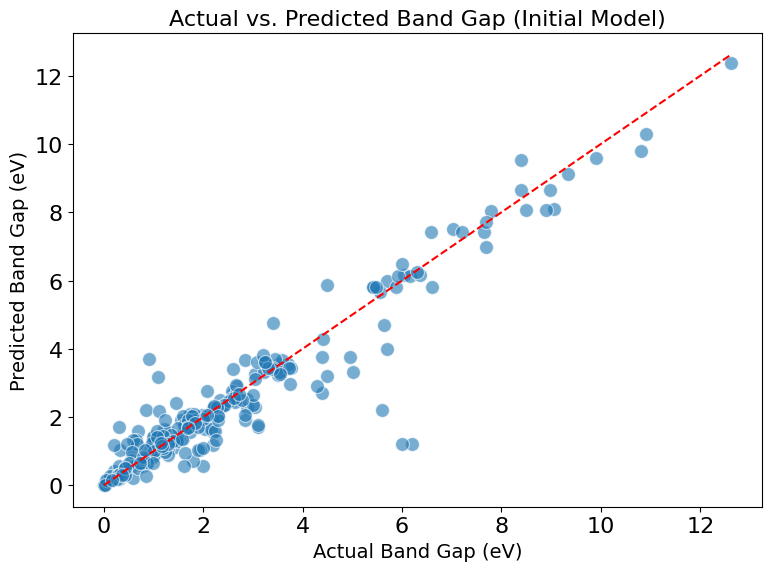

In [ ]:
# Scatter Plot: Actual vs. Predicted
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs. Predicted Band Gap', xlabel='Actual Band Gap (eV)', ylabel='Predicted Band Gap (eV)', figsize=(8, 6)):
    """
    Plots actual vs. predicted values to assess model performance.
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Diagonal line
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot actual vs. predicted band gap
plot_actual_vs_predicted(y_test, y_pred, title='Actual vs. Predicted Band Gap (Initial Model)')


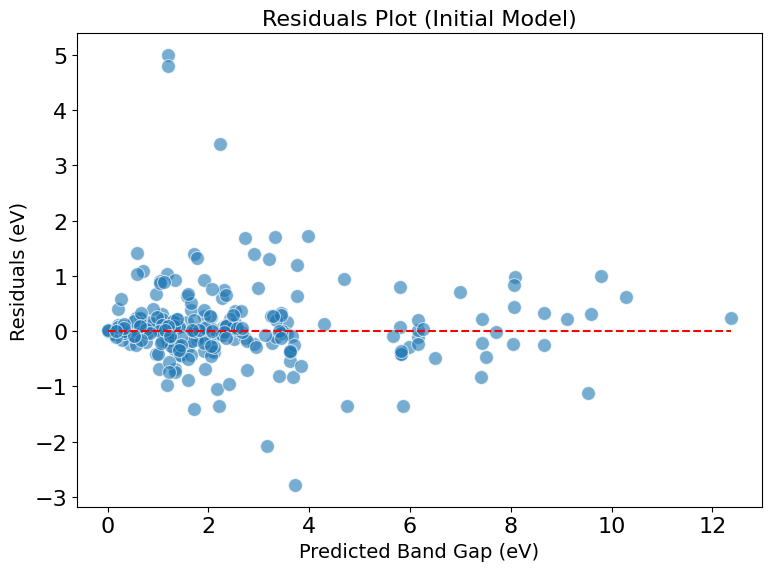

In [ ]:
# Residual Plot
def plot_residuals(y_true, y_pred, title='Residuals Plot', xlabel='Predicted Band Gap (eV)', ylabel='Residuals (eV)', figsize=(8, 6)):
    """
    Plots residuals to evaluate the model's prediction errors.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=figsize)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot residuals for the initial model
plot_residuals(y_test, y_pred, title='Residuals Plot (Initial Model)')


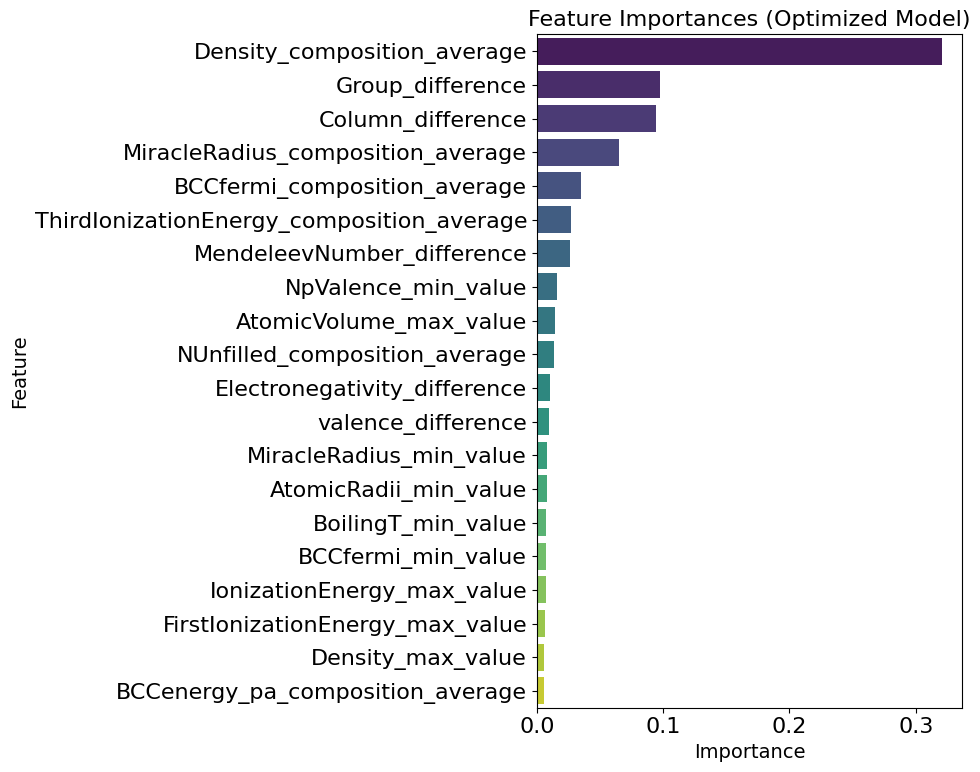

In [ ]:
# Feature Importance Plot
def plot_feature_importances(feature_importance_df, title='Feature Importances', top_n=20, figsize=(10, 8)):
    """
    Plots the top_n feature importances.
    """
    plt.figure(figsize=figsize)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot feature importances for the optimized model
plot_feature_importances(feature_importance_df, title='Feature Importances (Optimized Model)', top_n=20)


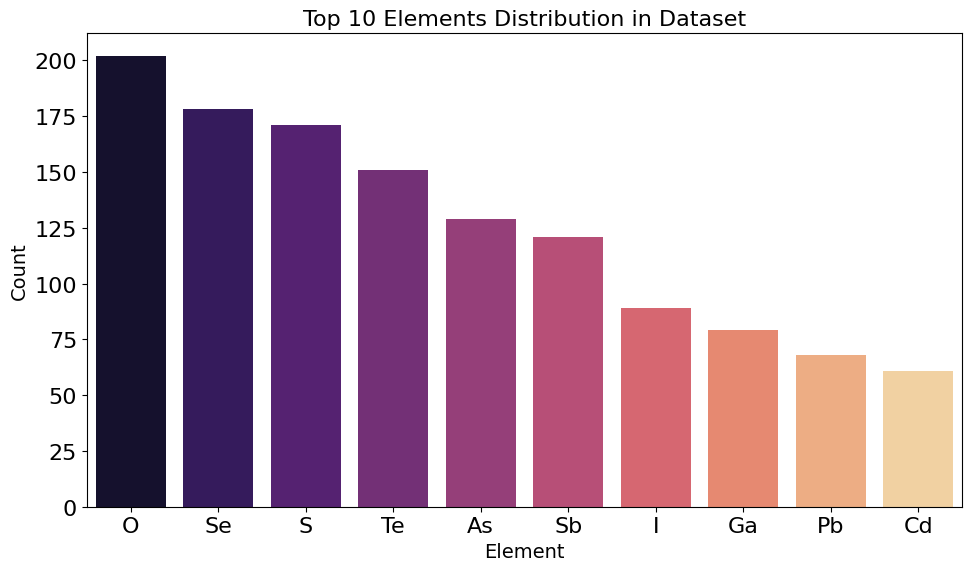

In [ ]:
# Distribution of Top Elements
def plot_top_elements(element_df_sorted, top_n=10, title='Top Elements Distribution', figsize=(10, 6)):
    """
    Plots the distribution of the top_n most common elements.
    """
    top_elements = element_df_sorted.head(top_n)
    plt.figure(figsize=figsize)
    sns.barplot(x='Element', y='Count', data=top_elements, palette='magma')
    plt.title(title, fontsize=16)
    plt.xlabel('Element', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot distribution of top 10 elements
plot_top_elements(element_df_sorted, top_n=10, title='Top 10 Elements Distribution in Dataset')


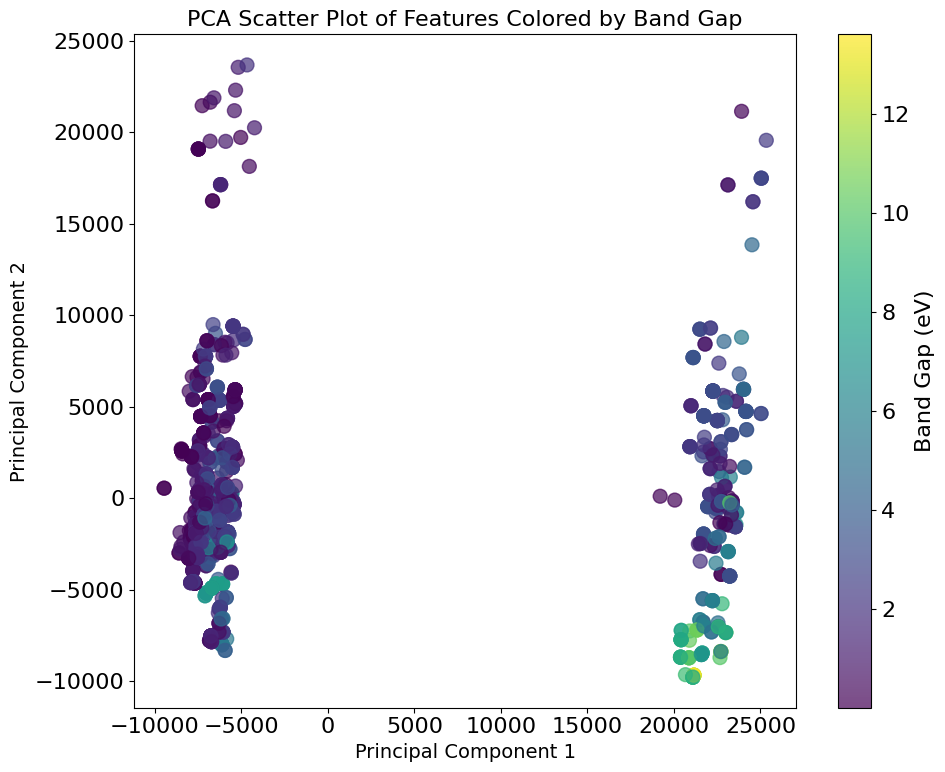

In [ ]:
# PCA Scatter Plot
def plot_pca(X, y, n_components=2, title='PCA Scatter Plot', figsize=(10, 8)):
    """
    Reduces the data to n_components using PCA and plots a scatter plot colored by target variable.
    """
    pca = PCA(n_components=n_components, random_state=seed)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Band Gap (eV)')
    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot PCA scatter plot
plot_pca(X, y, title='PCA Scatter Plot of Features Colored by Band Gap')


In [ ]:
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.tree import export_graphviz
import graphviz
from sklearn.manifold import TSNE
from scipy import stats
import shap


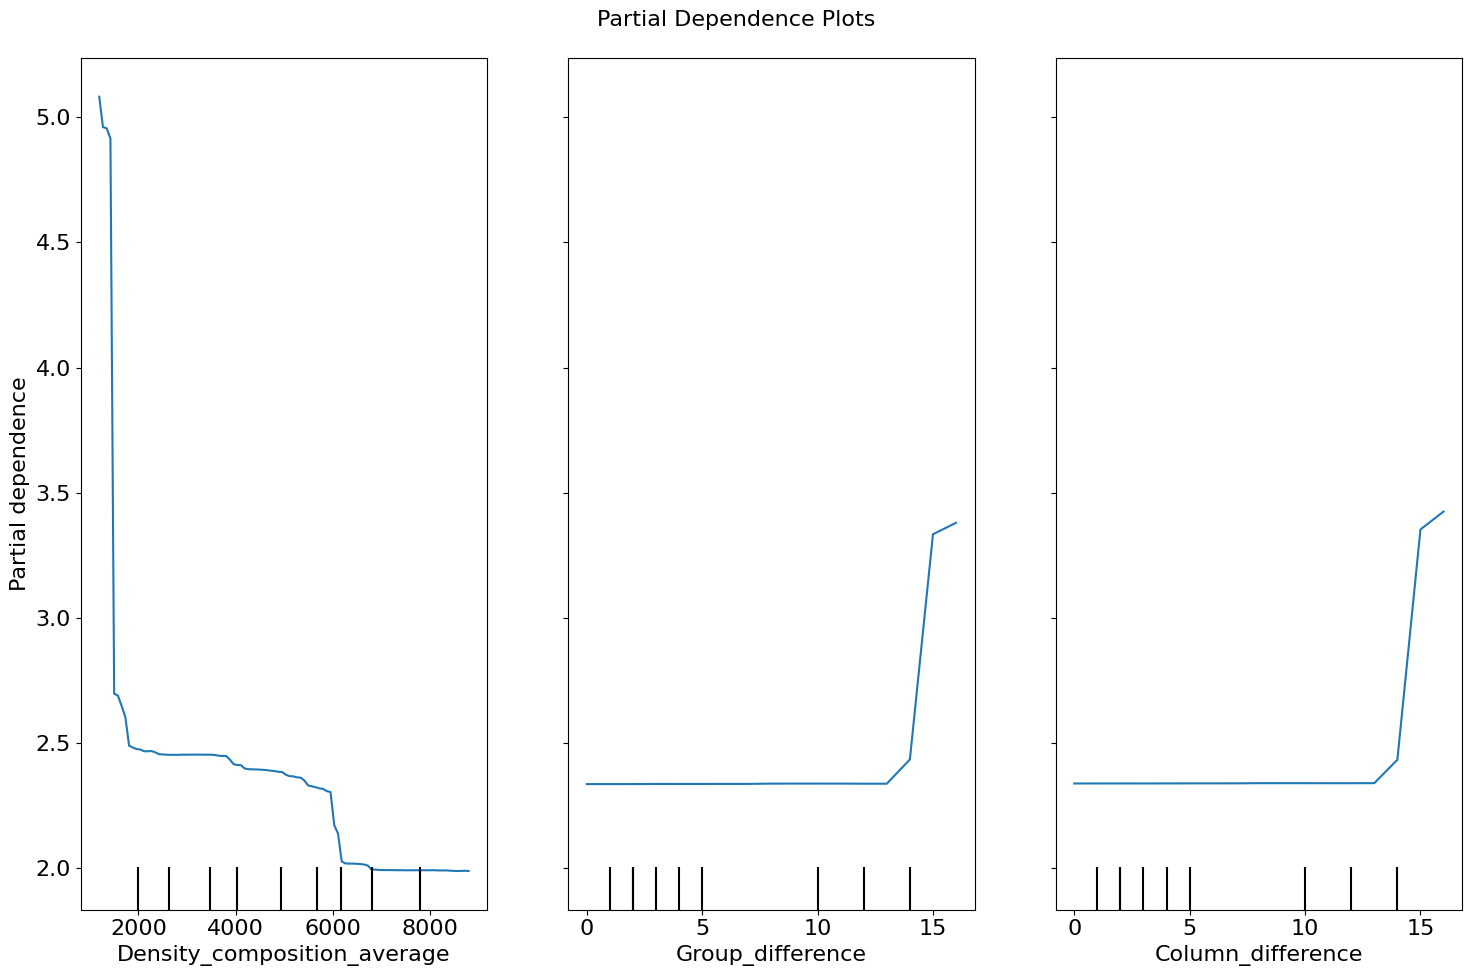

In [ ]:
# Partial Dependence Plots
def plot_partial_dependence(model, X, features, target='target', n_cols=2, figsize=(15, 10)):
    """
    Plots partial dependence for specified features.
    """
    fig, ax = plt.subplots(figsize=figsize)
    display = PartialDependenceDisplay.from_estimator(model, X, features, ax=ax, kind='average')
    plt.suptitle('Partial Dependence Plots', fontsize=16)
    plt.tight_layout()
    plt.show()

# Define features for PDP (e.g., top 3 features)
top_features = feature_importance_df['Feature'].head(3).tolist()

# Plot PDP for top features
plot_partial_dependence(best_pipeline, X, top_features, target='target', figsize=(15, 10))


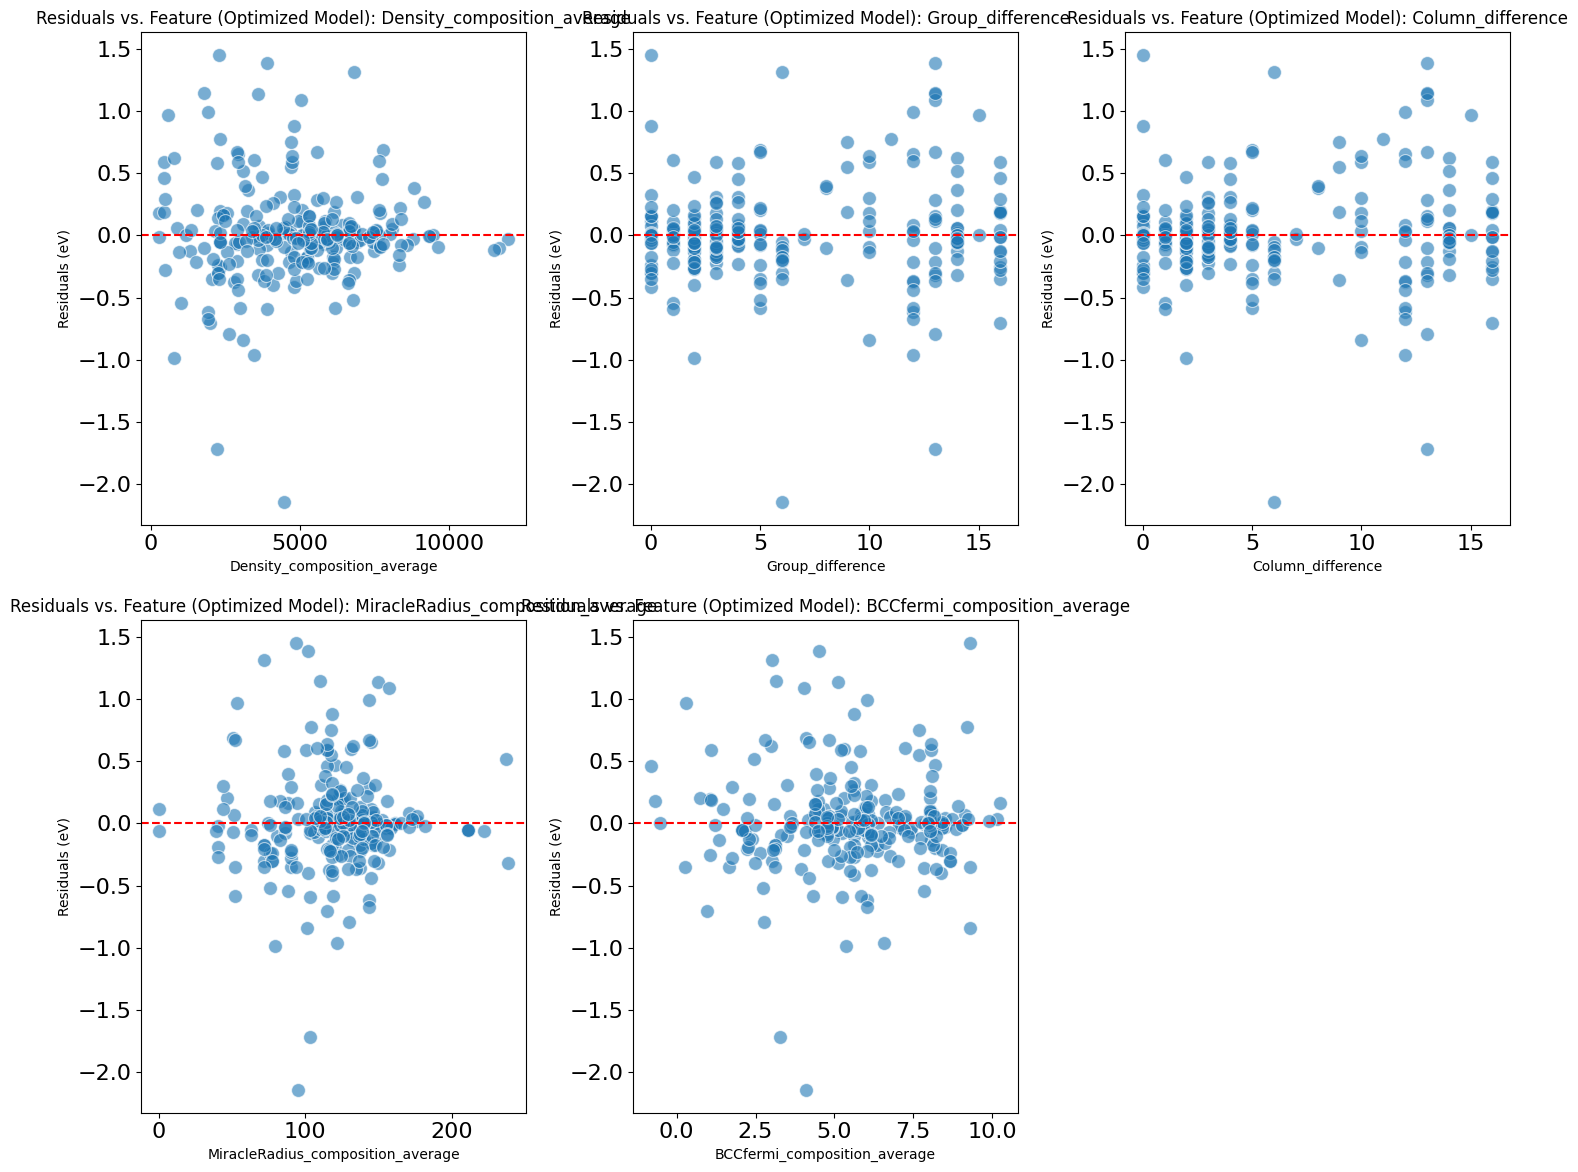

In [ ]:
# Residuals vs. Features Plots
def plot_residuals_vs_features(X, y_true, y_pred, features, title_prefix='Residuals vs. Feature', figsize=(15, 12)):
    """
    Plots residuals against specified features.
    """
    residuals = y_true - y_pred
    num_features = len(features)
    cols = 3
    rows = (num_features + cols - 1) // cols

    plt.figure(figsize=figsize)
    for i, feature in enumerate(features, 1):
        plt.subplot(rows, cols, i)
        sns.scatterplot(x=X[feature], y=residuals, alpha=0.6)
        plt.axhline(0, color='r', linestyle='--')
        plt.title(f'{title_prefix}: {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Residuals (eV)', fontsize=10)
    plt.tight_layout()
    plt.show()

# Define top features for residual plots
residual_features = feature_importance_df['Feature'].head(5).tolist()

# Plot residuals vs. top features for the optimized model
plot_residuals_vs_features(X, y_test, y_pred_optimized, residual_features, title_prefix='Residuals vs. Feature (Optimized Model)')


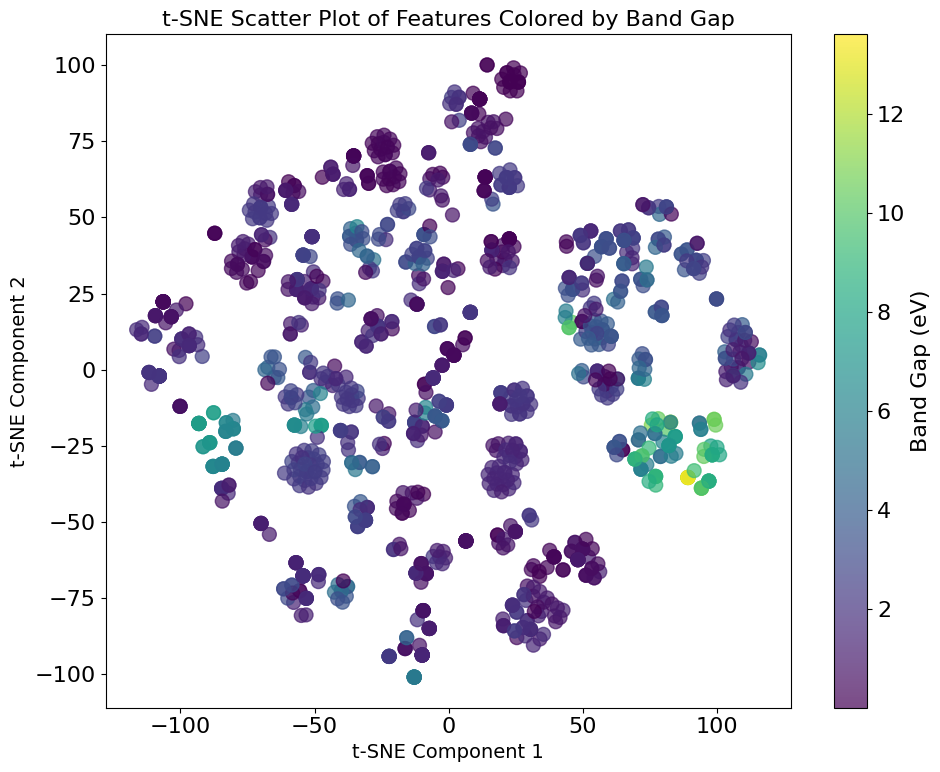

In [ ]:
# t-SNE Scatter Plot
def plot_tsne(X, y, title='t-SNE Scatter Plot', figsize=(10, 8)):
    """
    Reduces feature dimensions using t-SNE and plots a scatter plot colored by target variable.
    """
    tsne = TSNE(n_components=2, random_state=seed, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Band Gap (eV)')
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot t-SNE scatter plot
plot_tsne(X, y, title='t-SNE Scatter Plot of Features Colored by Band Gap')


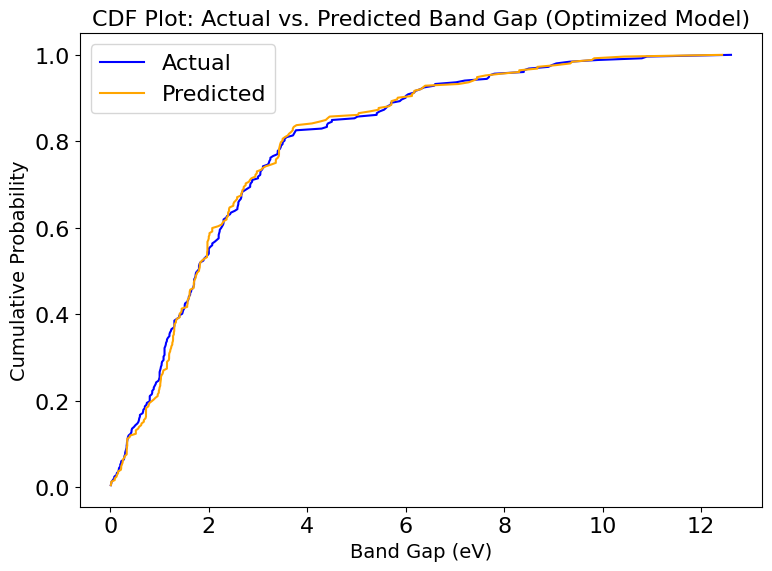

In [ ]:
# Cumulative Distribution Function (CDF) Plot
def plot_cdf(y_true, y_pred, title='CDF Plot: Actual vs. Predicted Band Gap', xlabel='Band Gap (eV)', ylabel='Cumulative Probability', figsize=(8, 6)):
    """
    Plots the cumulative distribution functions of actual and predicted values.
    """
    plt.figure(figsize=figsize)

    # Compute CDF for actual values
    sorted_true = np.sort(y_true)
    cdf_true = np.arange(1, len(sorted_true)+1) / len(sorted_true)
    plt.plot(sorted_true, cdf_true, label='Actual', color='blue')

    # Compute CDF for predicted values
    sorted_pred = np.sort(y_pred)
    cdf_pred = np.arange(1, len(sorted_pred)+1) / len(sorted_pred)
    plt.plot(sorted_pred, cdf_pred, label='Predicted', color='orange')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot CDF for actual vs. predicted Band Gap (Optimized Model)
plot_cdf(y_test, y_pred_optimized, title='CDF Plot: Actual vs. Predicted Band Gap (Optimized Model)')


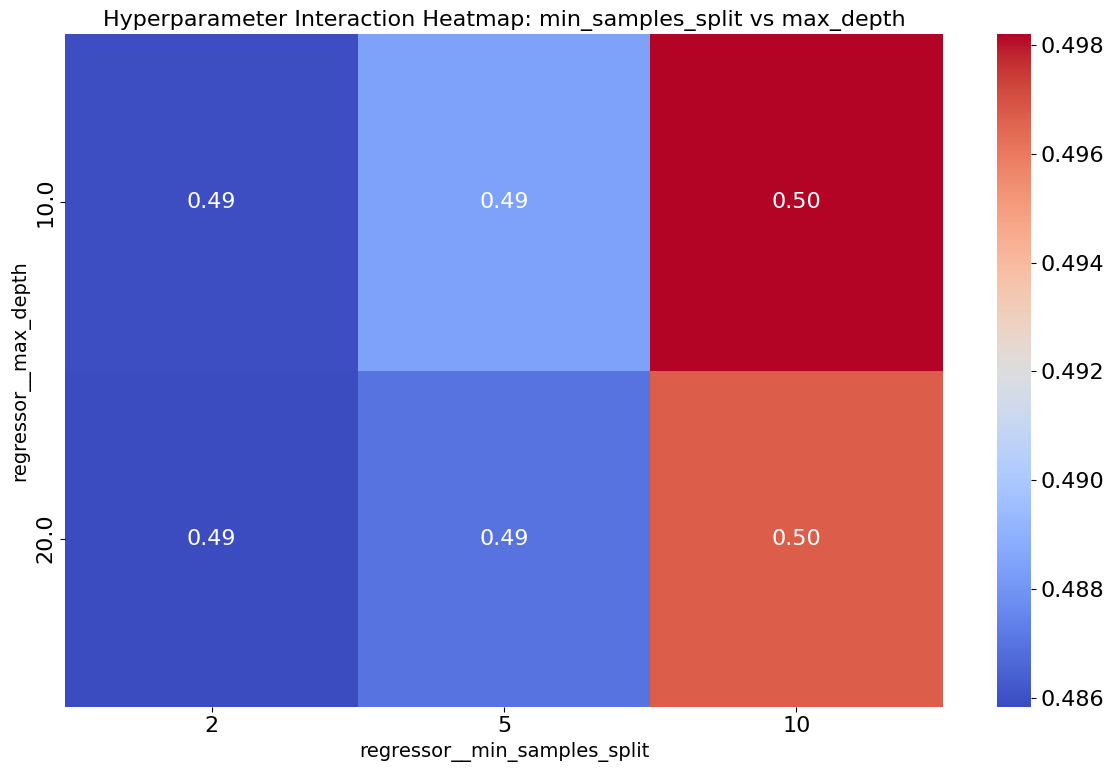

In [ ]:
# Heatmap of Hyperparameter Tuning Results for 'min_samples_split' vs 'max_depth'
def plot_hyperparameter_interaction_heatmap(grid_search, param1, param2, scoring='neg_mean_squared_error', title='Hyperparameter Interaction Heatmap', figsize=(12, 8)):
    """
    Plots a heatmap showing the interaction between two hyperparameters.
    """
    results = grid_search.cv_results_
    scores = results['mean_test_score']
    params = results['params']

    # Create a pivot table
    pivot_table = pd.pivot_table(
        pd.DataFrame({'param1': [p[param1] for p in params],
                      'param2': [p[param2] for p in params],
                      'score': scores}),
        values='score',
        index='param2',
        columns='param1',
        aggfunc=np.mean
    )

    # Convert scores to positive MSE
    pivot_table = -pivot_table

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title, fontsize=16)
    plt.xlabel(param1, fontsize=14)
    plt.ylabel(param2, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot interaction heatmap for 'min_samples_split' vs 'max_depth'
plot_hyperparameter_interaction_heatmap(
    grid_search,
    param1='regressor__min_samples_split',
    param2='regressor__max_depth',
    scoring='neg_mean_squared_error',
    title='Hyperparameter Interaction Heatmap: min_samples_split vs max_depth',
    figsize=(12, 8)
)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=seed)

# Create a pipeline
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', gb_model)
])

# Define hyperparameter grid
gb_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
}

# Set up GridSearchCV
gb_grid_search = GridSearchCV(
    gb_pipeline, gb_param_grid, cv=cv,
    scoring='neg_mean_squared_error', n_jobs=-1
)

# Fit the grid search to the data
gb_grid_search.fit(X, y)

# Best parameters
print("\nGradient Boosting Best Parameters:")
print(gb_grid_search.best_params_)

# Best cross-validation score
gb_best_cv_mse = -gb_grid_search.best_score_
print(f"Gradient Boosting Best Cross-Validation MSE: {gb_best_cv_mse:.3f}")

# Evaluate on test set
gb_best_pipeline = gb_grid_search.best_estimator_
y_pred_gb = gb_best_pipeline.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\nGradient Boosting Test MSE: {mse_gb:.3f}")
print(f"Gradient Boosting Test R^2 Score: {r2_gb:.3f}")



Gradient Boosting Best Parameters:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Gradient Boosting Best Cross-Validation MSE: 0.488

Gradient Boosting Test MSE: 0.150
Gradient Boosting Test R^2 Score: 0.972


In [ ]:
from sklearn.svm import SVR

# Define the SVR model
svr_model = SVR()

# Create a pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', svr_model)
])

# Define hyperparameter grid
svr_param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.1, 0.2, 0.5],
    'regressor__kernel': ['rbf', 'linear']
}

# Set up GridSearchCV
svr_grid_search = GridSearchCV(
    svr_pipeline, svr_param_grid, cv=cv,
    scoring='neg_mean_squared_error', n_jobs=-1
)

# Fit the grid search to the data
svr_grid_search.fit(X, y)

# Best parameters
print("\nSVR Best Parameters:")
print(svr_grid_search.best_params_)

# Best cross-validation score
svr_best_cv_mse = -svr_grid_search.best_score_
print(f"SVR Best Cross-Validation MSE: {svr_best_cv_mse:.3f}")

# Evaluate on test set
svr_best_pipeline = svr_grid_search.best_estimator_
y_pred_svr = svr_best_pipeline.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"\nSVR Test MSE: {mse_svr:.3f}")
print(f"SVR Test R^2 Score: {r2_svr:.3f}")



SVR Best Parameters:
{'regressor__C': 10, 'regressor__epsilon': 0.2, 'regressor__kernel': 'rbf'}
SVR Best Cross-Validation MSE: 0.518

SVR Test MSE: 0.172
SVR Test R^2 Score: 0.968


In [ ]:
pip install shap

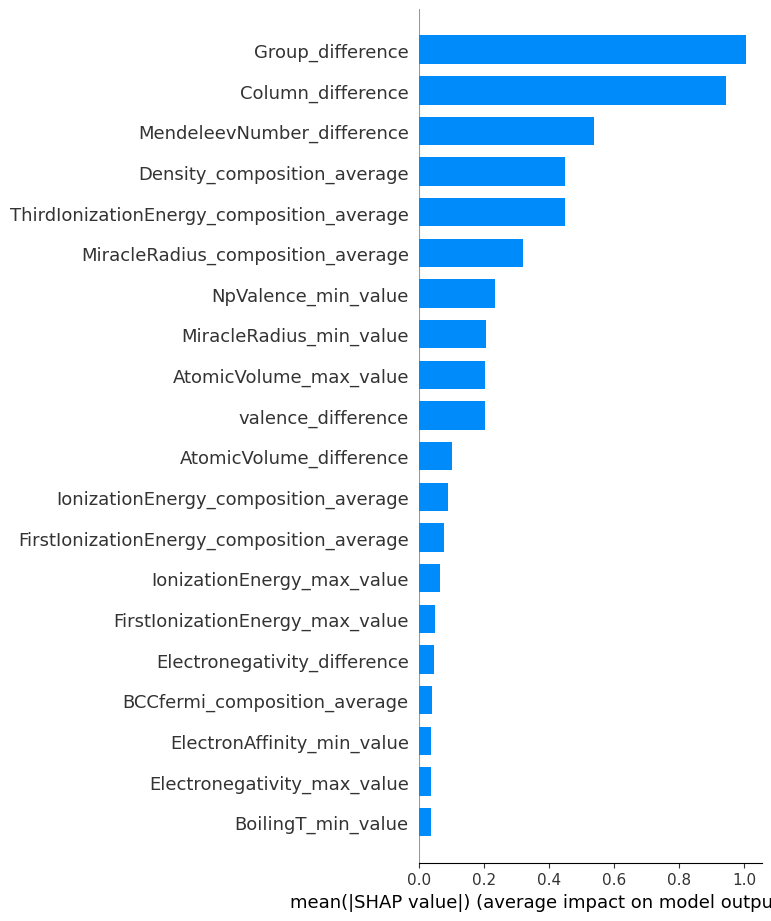

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['regressor'])

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

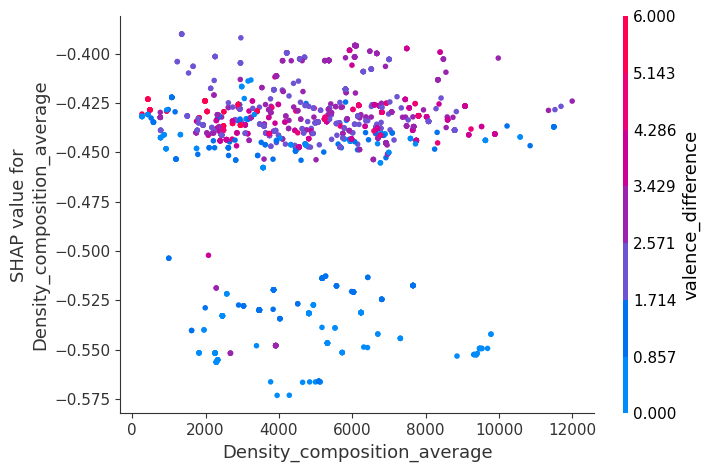

In [ ]:
# Choose a feature to analyze, e.g., the most important feature
top_feature = feature_importance_df.iloc[0]['Feature']

# Create a dependence plot for the top feature
shap.dependence_plot(top_feature, shap_values, X)

In [ ]:
import joblib

# Define the file path
model_filepath = 'best_random_forest_model.joblib'

# Save the model
joblib.dump(best_pipeline, model_filepath)
print(f"\nModel saved to {model_filepath}")

# To load the model later
# loaded_model = joblib.load(model_filepath)
# y_loaded_pred = loaded_model.predict(X_test)


Model saved to best_random_forest_model.joblib
